# Exercise 3 - GNNs Solutions
## Protein-Protein Interaction Prediction using Graph Neural Networks

In this exercise, you will learn how to implement and apply Graph Neural Networks (GNNs) to predict [protein-protein interactions](https://en.wikipedia.org/wiki/Protein%E2%80%93protein_interaction) (PPIs). GNNs have shown great potential in various biological applications, including predicting protein functions, drug discovery, and more.

Protein-protein interactions (PPIs) are essential to almost every process in a cell. Understanding PPIs is crucial for understanding cell physiology in normal and disease states. Furthermore, knowledge of PPIs can be used:
* for drug development, since drugs can affect PPIs,
* to assign roles (i.e., protein functions) to uncharacterized proteins,
* to characterize the relationships between proteins that form multi-molecular complexes, such as the proteasome.

We represent the totality of PPIs that happen in a cell, an organism or a specific biological context with a protein-protein interaction network. These networks are mathematical representations of all physical contacts between proteins in the cell.

However, current knowledge of protein-protein interaction networks is both incomplete and noisy, as PPI screening techniques are limited in how many true interactions they can detect. Furthermore, PPI screening techniques often have high false positive and negative rates. These limitations present a great opportunity for computational methods to predict protein-protein interactions.

Therefore, we are interested to take a protein-protein interaction network and use it to build a model for predicting new protein-protein interactions. We formulate this prediction task as a **link prediction problem** on unweighted and undirected networks and use a graph neural network to solve the task.

We will use a sample protein-protein interaction network from [yeast *S. cerevisiae*](https://en.wikipedia.org/wiki/Saccharomyces_cerevisiae), in the form of an adjacency matrix and node feature matrix. Each node represents a protein, and the goal is to predict whether two proteins interact, i.e., is there an edge between the two nodes.

## 1. Setup
Let's import the necessary libraries. Note that this week, we'll implement the GNNs in pure [PyTorch](https://pytorch.org/docs/stable/index.html).

In [1]:
%matplotlib inline

import time
import networkx as nx

import numpy as np
from scipy import sparse as sp
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve
import torch
from torch import nn
import torch.nn.functional as F

## 2. Data

### 2.1. Downloading the data
First, download the data from [here](https://snap.stanford.edu/deepnetbio-ismb/ipynb/yeast.edgelist) and copy it into a file called `yeast.edgelist`. This data contains the edges between the proteins.
We then build a graph from this edge-list data, and extract the adjacency matrix.

For this exercise, we will sample a subset of the graph to make it faster and easier.

The entire dataset is represented as a single graph and our goal will be to train a GNN to predict new edges on this graph, representing potential new protein-protein interactions.

In [2]:
# Some utility functions
def load_data(filename='yeast.edgelist'):
    """Load the edgelist data and build a graph from it."""
    graph = nx.read_edgelist(filename)
    adjacency = nx.adjacency_matrix(graph)
    return graph, adjacency

def subsample_graph(graph, max_nodes=1000):
    """Sub-sample the graph to make it smaller."""
    graph = graph.subgraph(np.random.choice(graph.nodes(), max_nodes, replace=False)).copy()
    graph = graph.subgraph(sorted(nx.connected_components(graph), key=len, reverse=True)[0]).copy()  # keep only the largest connected component
    graph.remove_nodes_from(list(nx.isolates(graph)))
    adjacency = nx.adjacency_matrix(graph)
    return graph, adjacency

def get_edge_index(adjacency):
    """Return the indices of the edges in the graph."""
    # Edges are undirected here, so we consider only one half of the adjacency matrix
    adjacency = sp.triu(adjacency)
    return np.stack(adjacency.nonzero(), axis=0)

In [3]:
# Load the data and prepare a subgraph
graph, adjacency = load_data('yeast.edgelist')
graph, adjacency = subsample_graph(graph, max_nodes=1000)
edge_index = get_edge_index(adjacency)
print(graph)

N_NODES = adjacency.shape[0]
N_EDGES = edge_index.shape[1]

Graph with 926 nodes and 12681 edges


### 2.2. Data splitting

Now, let's split the data into training, validation, and test sets. To create the validation and test sets, we will select some existing edges to create positive examples and then sample some absent edges (by verifying they are not in the graph) to have negative examples.

So, for each set, we:
1. sample X% of the edges as the positive examples,
2. create negative examples by selecting pairs of node that are not connected in the original graph, as many as we have positive edges.

Finally, the train set will consist of the rest of the edges. In order to avoid training on the validation and test edges, we also build a mask for the adjacency matrix that will indicate if we supervise a given edge during training.

In [4]:
TEST_EDGE_RATIO = 0.05  # percent of edges to use for the validation and test set respectively

def split_graph_edges(adj, edge_index, test_edge_ratio=TEST_EDGE_RATIO):
    """Split the graph into train, valid and test edge sets."""
    # Get validation and test edges
    n_valid = n_test = int(N_EDGES * test_edge_ratio)
    valid_edges = edge_index[:, :n_valid]
    test_edges = edge_index[:, n_valid:n_valid + n_test]

    # Remove them from the training set
    train_edges = edge_index[:, n_valid + n_test:]

    # Sample "negative edges" for validation and test sets
    # As the adjacency matrix is sparse, we can sample them
    # randomly instead of enumerating all non-edges.
    neg_edge = []
    num_neg = n_valid + n_test
    while len(neg_edge) < num_neg:
        i, j = np.random.randint(0, N_NODES, size=(2,))
        if i != j and adj[i, j] == 0 and [i, j] not in neg_edge:
            neg_edge.append([i, j])
    valid_edges_neg = np.array(neg_edge[:n_valid]).T
    test_edges_neg = np.array(neg_edge[n_valid:]).T

    # Rebuild the training adjacency matrix
    adj_train = sp.csr_matrix((np.ones(train_edges.shape[1]), train_edges), shape=adj.shape)
    adj_train = adj_train + adj_train.T - sp.diags(adj_train.diagonal(), dtype=int)
    train_edges = get_edge_index(adj_train)
    
    # Build a training mask to avoid training on valid/test edges
    train_mask = np.ones(adj_train.shape, dtype=bool)
    for edges in [valid_edges, valid_edges_neg, test_edges, test_edges_neg]:
        train_mask[edges[0], edges[1]] = False
        train_mask[edges[1], edges[0]] = False  # also remove the reverse direction

    return adj_train, train_edges, train_mask, valid_edges, valid_edges_neg, test_edges, test_edges_neg

adj_train, train_edges, train_mask, valid_edges, valid_edges_neg, test_edges, test_edges_neg = split_graph_edges(adjacency, edge_index, TEST_EDGE_RATIO)
print(f"Edges split into:\n training: {train_edges.shape[1]}\n validation: {valid_edges.shape[1]}\n test: {test_edges.shape[1]}")

n_pos_edge = adj_train[train_mask].sum()
n_neg_edge = (1 - adj_train.todense())[train_mask].sum()
pos_weight = n_neg_edge / n_pos_edge  # weight of positive edges to compensate for the large imbalance
print(f"Ratio of negative/positive edges: {pos_weight:.2f}")

Edges split into:
 training: 11413
 validation: 634
 test: 634
Ratio of negative/positive edges: 36.75


Let's visualize (a part of) the graph data below. Note that we randomly sample nodes for this visualization, so it is possible we end up with more than a single connected component, even though the full graph has only one.

Graph with 166 nodes and 379 edges


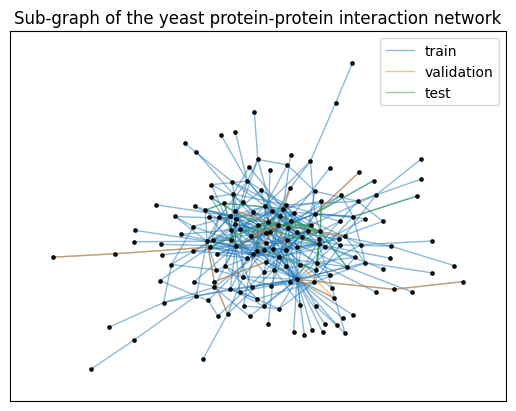

In [5]:
N = 200  # number of node to keep for the visualization

nodelist = np.random.permutation(graph.nodes())[:N]
subgraph = graph.subgraph(nodelist).copy()
subgraph.remove_edges_from(list(nx.selfloop_edges(subgraph)))  # remove self-loops for visualization
subgraph.remove_nodes_from(list(nx.isolates(subgraph)))  # remove isolated nodes for visualization
print(subgraph)

pos = nx.spring_layout(subgraph, iterations=100)

fig, ax = plt.subplots(1, 1)
ax.set_title('Sub-graph of the yeast protein-protein interaction network')
for edge_set, color in [(train_edges, 'C0'), (valid_edges, 'C1'), (test_edges, 'C2')]:
    edgelist = subgraph.edges(np.array(graph.nodes())[edge_set[0]])
    nx.draw_networkx(subgraph, pos, edgelist=edgelist, ax=ax, with_labels=False, node_size=5, node_color='black', edge_color=color, width=1., alpha=0.5)
ax.legend([Line2D([], [], color=c, linewidth=1., alpha=0.5) for c in ('C0', 'C1', 'C2')], ['train', 'validation', 'test']);

### 2.3. Preparing the data

Now, we can prepare the data for PyTorch. The model takes as input the node embeddings and the adjacency matrix, and will predict edges.

Note that this dataset does not have any node embeddings, the only available information are the existing interactions (the edges). So we will manually create embeddings for every node.

In [6]:
def sparse_array_to_tensor(adj):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    adj = adj.tocoo()
    return torch.sparse_coo_tensor(
        torch.LongTensor(np.vstack((adj.row, adj.col))), 
        torch.FloatTensor(adj.data),
        torch.Size(adj.shape)
    )

# Convert the data to PyTorch tensors
data = {
    'adj_train': sparse_array_to_tensor(adj_train).to_dense(),  # adjacency matrix of training set
    'train_edges': torch.LongTensor(train_edges),               # indices of edges in the training set
    'train_mask': torch.BoolTensor(train_mask),                 # boolean mask of edges in the training set
    'valid_edges': torch.LongTensor(valid_edges),               # indices of edges in the validation set
    'valid_edges_neg': torch.LongTensor(valid_edges_neg),       # indices of negative edges in the validation set
    'test_edges': torch.LongTensor(test_edges),                 # indices of edges in the test set
    'test_edges_neg': torch.LongTensor(test_edges_neg),         # indices of negative edges in the test set
}

# Embed the nodes as one-hot vectors
D_NODES = N_NODES  # number of dimensions
data['x_train'] = torch.eye(N_NODES)

## 3. Graph Neural Networks
Let's implement here a basic GNN using PyTorch.

### 3.1. Graph Convolutional Layers
Start by implementing layers to perform graph convolutions with simple neighborhood aggregation. They will be useful to build the Deep Graph Encoder part of the whole GNN model.

<img src="img/neighb_agg.png" width="600" />

As a reminder, the equation you saw in the course for such a layer is:
$$
\mathbf{h}_v^{(l+1)} = \sigma\left( \mathbf{W}_l \sum_{u\in N(v)} \frac{\mathbf{h}_u^{(l)}}{|N(v)|} + \mathbf{B}_l \mathbf{h}_v^{(l)} \right),
$$
where $v$ index the node, $l$ the layer, $\mathbf{h}$ are the node embeddings, $\sigma$ is a non-linearity, $N(v)$ is the set of neighbor of node $v$, and $\mathbf{W}$ and $\mathbf{B}$ are the trainable weight matrices of the layer. Or, in matrix form with the adjacency matrix (corrected by the inverse of the degree) $\tilde{A}$:
$$
H^{(l+1)} = \sigma\left( \tilde{A}H^{(l)}W_l^\top + H^{(l)}B_l^\top \right).
$$

**Note**: because of our naive data splitting and the sparsity of connections in the graph, some node may have no neighbors. For these nodes, be careful about the neighborhood aggregation as their degree is 0!

In [7]:
class GraphConv(nn.Module):
    """Basic graph convolutional layer implementing the simple neighborhood aggregation."""

    def __init__(self, in_features, out_features, activation=None):
        """
        Initialize the graph convolutional layer.
        
        Args:
            in_features (int): number of input node features.
            out_features (int): number of output node features.
            activation (nn.Module or callable): activation function to apply. (optional)
        """
        super().__init__()
        self.activation = activation

        # Learnable weight matrices, using linear layers
        self.weight = nn.Linear(in_features, out_features, bias=False)
        self.bias = nn.Linear(in_features, out_features, bias=False)

    def forward(self, x, adj):
        """
        Perform graph convolution operation.

        Args:
            x (Tensor): Input node features of shape (num_nodes, in_features).
            adj (Tensor): Adjacency matrix of the graph, shape (num_nodes, num_nodes).

        Returns:
            Tensor: Output node features after graph convolution, shape (num_nodes, out_features).
        """
        # Neighbourhood aggregation
        adj = adj / adj.sum(1, keepdim=True).clamp(min=1)
        x_agg = torch.matmul(adj, x)

        # Perform graph convolution
        x = self.weight(x_agg) + self.bias(x)

        # Apply activation function (e.g., ReLU)
        if self.activation is not None:
            x = self.activation(x)
        return x

Let's do a quick test to verify if it runs:

In [8]:
conv = GraphConv(D_NODES, 5, nn.ReLU())
out = conv(data['x_train'], data['adj_train'])

assert out.shape == (N_NODES, 5), f"Output shape should be (num_nodes, out_features), was {out.shape}"

### 3.2. Prediction head

In this exercise, we are interested in predicting potential new protein-protein interactions, meaning we want to do *edge prediction*.

<img src="img/edge_pred.png" width="300" />

In the lecture, you have seen two possibilities for the prediction heads at edge-level: (1) Concatenation + Linear or (2) Dot product. 

A potential problem with (1) is that it's not a symmetric operation, as $\mathrm{Concat}\left(\mathbf{h}_v, \mathbf{h}_u\right) \neq \mathrm{Concat}\left(\mathbf{h}_u, \mathbf{h}_v\right)$ in the general case. If  we have *directed* edges, this can be beneficial, but here the edges are undirected.

In this exercise, as we want to do 1-way prediction (is there an edge or not) we only ask you to implement (2):
* `DotProductHead`: dot product between the node embeddings, and we add a linear transformation on the results: $\hat{\mathbf{y}}_{uv} = w\left( \mathbf{h}_v ^\top \mathbf{h}_u\right) + b$, where $w$ and $b$ are both trainable parameters.

**Remark**: to get a probability for each edge, we could use the sigmoid function on the final results: $\mathrm{sigmoid}(\hat{\mathbf{y}}_{uv})$. However, here we will not directly include it in the model. The reason is that during training, we'll then be able to use [`torch.nn.BCEWithLogitsLoss`](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html?highlight=bcewithlogits#torch.nn.BCEWithLogitsLoss) instead of [`torch.nn.BCELoss`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html?highlight=bce#torch.nn.BCELoss), which is more stable numerically.
Then, when using the model for prediction, we will manually apply the sigmoid on its output to get probabilities.

In [9]:
class DotProductHead(nn.Module):
    """Prediction head using dot product between node embeddings for edge prediction."""

    def __init__(self):
        """Initialize the prediction head."""
        super().__init__()
        self.linear = nn.Linear(1, 1)

    def forward(self, x):
        """
        Edge-level prediction given the node embeddings.

        Args:
            x (Tensor): Input node features of shape (num_nodes, in_features).

        Returns:
            Tensor: Edge predictions of shape (num_nodes, num_nodes).
        """
        x = (x @ x.transpose(0, 1))
        return self.linear(x.unsqueeze(-1)).squeeze(-1)

In [10]:
# Let's do a quick test as well.
head = DotProductHead()
out = head(data['x_train'])

assert out.shape == (N_NODES, N_NODES), f"Output shape should be (num_nodes, num_nodes), was {out.shape}"

### 3.3. GNN full model
Implement the entire GNN model, which consists in an initial Deep Graph Encoder part, to obtain node embeddings, followed by a prediction head.

<img src="img/gnn_net.png" width="700" />

**Important**: as our prediction head is a simple dot product, it might be better to avoid having an activation function on the previous layer. Indeed, for example, a ReLU would prevent any negative values, so that all the dot product would be strictly positive!

In [11]:
class GNN(nn.Module):
    """A full Graph Neural Network for edge prediction."""

    def __init__(self, num_features, conv_dims, activation, dropout=0.):
        """
        Initialize the GNN model for edge prediction.

        Args:
            num_features (int): Number of input node features.
            conv_dims (list of int): Number of hidden features in each graph convolution layers.
            activation (nn.Module or callable): Activation function to apply.
            dropout (float): Dropout probability. (optional)
        """
        super().__init__()
        self.activation = activation
        self.dropout = dropout

        # Deep Graph Encoder layers
        self.conv_layers = nn.ModuleList()
        self.conv_layers.append(GraphConv(num_features, conv_dims[0], activation))
        for i in range(len(conv_dims) - 2):
            self.conv_layers.append(GraphConv(conv_dims[i], conv_dims[i+1], activation))
        self.conv_layers.append(GraphConv(conv_dims[-2], conv_dims[-1], None))

        # We add Batch normalization layers to help with training
        self.norms = nn.ModuleList()
        for dim in conv_dims:
            self.norms.append(nn.BatchNorm1d(dim))

        # Prediction head
        self.head = DotProductHead()

    def forward(self, x, adj):
        """
        Perform forward pass for edge prediction.

        Args:
            x (Tensor): Input node features of shape (num_nodes, num_features).
            adj (Tensor): Adjacency matrix of the graph, shape (num_nodes, num_nodes).

        Returns:
            Tensor: Predicted edge probabilities for each pair of nodes, shape (num_nodes, num_nodes).
        """
        # Apply multiple graph convolution layers
        for layer, norm in zip(self.conv_layers, self.norms):
            x = layer(x, adj)
            x = norm(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        # Predict edges presence
        x = self.head(x)

        return x

Again, let's quickly verify that our model runs:

In [12]:
model = GNN(num_features=D_NODES, conv_dims=[5, 5], activation=nn.ReLU())
out = model(data['x_train'], data['adj_train'])

assert out.shape == (N_NODES, N_NODES), f"Output shape should be (num_nodes, num_nodes), was {out.shape}"

## 4. Training

### 4.1. Utilities
Define functions to implement a *single training step*, compute train and test metrics, and visualize the Receiver Operating Characteristic Curbe (ROC curve), see [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html).

For the metrics, we use scikit-learn to compute the following:
1. `roc_auc_score`: Area Under the Receiver Operating Characteristic Curve (ROC AUC), see [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html).
2. `average_precision_score`: Average Precision (AP), see [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html).

In [13]:
def train_step(data, model, loss_fn, optimizer):
    """
    Train the model for one step on the network data.

    Hint: do not forget to mask the loss!
    
    Args:
        data (dict): Dictionary of tensors containing the data.
        model (nn.Module): Model to be trained.
        loss_fn (nn.Module): Loss function to be optimized.
        optimizer (torch.optim.Optimizer): Optimizer to use for training.

    Returns:
        float: Loss value.
    """
    # Set model to train mode
    model.train()

    # Compute prediction and loss
    pred = model(data['x_train'], data['adj_train'])
    loss = loss_fn(pred[data['train_mask']], 
                   data['adj_train'][data['train_mask']])

    # 1. Set the gradient of trainable parameters to 0.
    optimizer.zero_grad()
    # 2. Automatically calculate the gradient of trainable parameters.
    loss.backward()
    # 3. Automatically update the trainable parameters using the gradient.
    optimizer.step()

    # Return the loss
    return loss.item()


@torch.no_grad()  # decorator to deactivate autograd functionality in this function
def get_train_accuracy(data, model, threshold=0.5):
    """
    Compute accuracy of the edge prediction on the training data.

    Hint: do not forget to mask the train edges.

    Args:
        data (dict): Dictionary of tensors containing the data.
        model (nn.Module): Model to be tested.

    Returns:
        tuple(float, float): Accuracy for positive edges, accuracy for negative edges (in %).
    """
    # Set the model to evaluation mode
    model.eval()

    # Predictions (binary)
    pred = model(data['x_train'], data['adj_train'])
    pred = torch.sigmoid(pred) >= threshold

    # Compute the accuracy for positive and negative edges
    acc_pos = pred[data['adj_train'].bool() & data['train_mask']].sum().item() / n_pos_edge * 100
    acc_neg = (~pred)[~data['adj_train'].bool() & data['train_mask']].sum().item() / n_neg_edge * 100

    return acc_pos, acc_neg


@torch.no_grad()
def test(data, model, edges_pos, edges_neg):
    """
    Test the model's prediction on the positive and negative edges.

    Args:
        data (dict): Dictionary of tensors containing the data.
        model (nn.Module): Model to be tested.
        edges_pos (Tensor): Positive edges to be predicted.
        edges_neg (Tensor): Negative edges to be predicted.

    Returns:
        tuple(float, float): Area under ROC curve, and average precision metrics.
    """
    # Set the model to evaluation mode
    model.eval()

    # Predictions
    pred = model(data['x_train'], data['adj_train'])
    pred = torch.sigmoid(pred)

    # Select the predictions corresponding to the positive and negative edges
    pred_pos = pred[edges_pos[0], edges_pos[1]]
    pred_neg = pred[edges_neg[0], edges_neg[1]]

    # Stack the predictions and true values
    pred_all = torch.cat([pred_neg, pred_pos])
    labels_all = torch.cat([torch.zeros_like(pred_neg), torch.ones_like(pred_pos)])

    # Compute the metrics
    roc_score = roc_auc_score(labels_all, pred_all)
    ap_score = average_precision_score(labels_all, pred_all)
    return roc_score, ap_score


@torch.no_grad()
def plot_roc_curve(data, model, edges_pos, edges_neg):
    """
    Plot the ROC curve given the positive and negative edges.

    Args:
        data (dict): Dictionary of tensors containing the data.
        model (nn.Module): Model to be tested.
        edges_pos (Tensor): Positive edges to be predicted.
        edges_neg (Tensor): Negative edges to be predicted.

    Returns:
        matplotlib.figure.Figure: The ROC curve figure.
    """
    # Set the model to evaluation mode
    model.eval()

    # Predictions
    pred = model(data['x_train'], data['adj_train'])
    pred = torch.sigmoid(pred)

    # Select the predictions corresponding to the positive and negative edges
    pred_pos = pred[edges_pos[0], edges_pos[1]]
    pred_neg = pred[edges_neg[0], edges_neg[1]]

    # Stack the predictions and true values
    pred_all = torch.cat([pred_neg, pred_pos])
    labels_all = torch.cat([torch.zeros_like(pred_neg), torch.ones_like(pred_pos)])

    # Compute the false positive rate and true positive rate
    fpr, tpr, _ = roc_curve(labels_all, pred_all)

    # Plot the ROC curve
    fig, ax = plt.subplots(1, 1)
    ax.plot(fpr, tpr, label='ROC curve\n(with threshold values)')
    ax.set_xlim(0., 1.)
    ax.set_ylim(0., 1.)
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.set_title('ROC curve')
    ax.grid()
    return fig

### 4.2. Complete training
We will now combine everything to train and evaluate our model.

The main steps are:
1. Prepare and preprocess the data (already done above)
2. Define the model
3. Define the training loss and optimizer
4. Train the model

In [14]:
# Hyper-parameters (feel free to change these)
learning_rate = 1e-3
epochs = 400
conv_dims = [512, 256]
activation = nn.LeakyReLU()
dropout = 0.1

# 1. Data
# We already loaded and prepared the data above

# 2. Model
model = GNN(num_features=D_NODES, conv_dims=conv_dims, activation=activation, dropout=dropout)
#print(model)

# 3. Initialize the loss function and optimizer
# We weight the samples to compensate for the class imbalance (there are very few edges compared to non-edges)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight))
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

history = {"epoch": 0, "loss": [], "acc-pos": [], "acc-neg": [], "val-roc": [], "val-ap": []}

Epoch   1/400: loss: 1.2534 - acc-pos: 100.0% - acc-neg: 18.8% - val-roc: 0.4390 - val-ap: 0.4435 (0.1s/epoch)
Epoch   2/400: loss: 1.2463 - acc-pos: 100.0% - acc-neg: 18.8% - val-roc: 0.4375 - val-ap: 0.4429 (0.1s/epoch)
Epoch   3/400: loss: 1.2496 - acc-pos: 100.0% - acc-neg: 18.8% - val-roc: 0.4383 - val-ap: 0.4433 (0.1s/epoch)
Epoch   4/400: loss: 1.2516 - acc-pos: 100.0% - acc-neg: 19.1% - val-roc: 0.4417 - val-ap: 0.4449 (0.1s/epoch)
Epoch   5/400: loss: 1.2410 - acc-pos: 100.0% - acc-neg: 19.2% - val-roc: 0.4486 - val-ap: 0.4485 (0.1s/epoch)
Epoch   6/400: loss: 1.2410 - acc-pos: 100.0% - acc-neg: 19.4% - val-roc: 0.4546 - val-ap: 0.4517 (0.1s/epoch)
Epoch   7/400: loss: 1.2346 - acc-pos: 100.0% - acc-neg: 19.5% - val-roc: 0.4585 - val-ap: 0.4540 (0.1s/epoch)
Epoch   8/400: loss: 1.2432 - acc-pos: 100.0% - acc-neg: 19.6% - val-roc: 0.4597 - val-ap: 0.4551 (0.1s/epoch)
Epoch   9/400: loss: 1.2433 - acc-pos: 100.0% - acc-neg: 19.2% - val-roc: 0.4600 - val-ap: 0.4553 (0.1s/epoch)
E

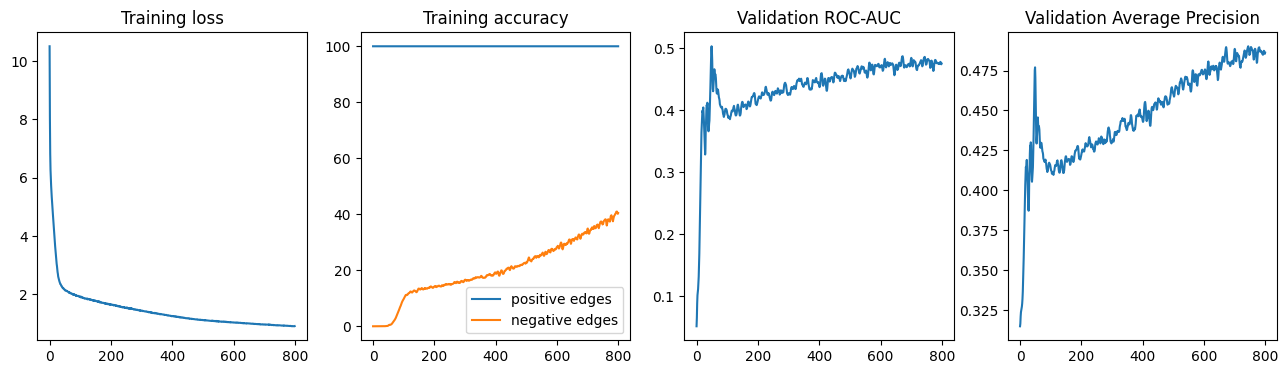

In [16]:
# 4. Main training loop
def train_loop(history, data, model, loss_fn, optimizer, epochs):
    """Full training loop over the dataset for several epochs."""
    for t in range(epochs):
        start_epoch = time.time()  # time the epoch
        print(f"Epoch {t+1: 3d}/{epochs}:", end="")

        # Training step
        train_loss = train_step(data, model, loss_fn, optimizer)
        print(f" loss: {train_loss:.4f}", end="")

        # Trainin accuracy
        acc_pos, acc_neg = get_train_accuracy(data, model, threshold=0.5)
        print(f" - acc-pos: {acc_pos:.1f}% - acc-neg: {acc_neg:.1f}%", end="")

        # Validation
        valid_roc, valid_ap = test(data, model, data['valid_edges'], data['valid_edges_neg'])
        print(f" - val-roc: {valid_roc:.4f} - val-ap: {valid_ap:.4f}", end="")
            
        # Log
        history['epoch'] += 1
        history['loss'].append(train_loss)
        history['acc-pos'].append(acc_pos)
        history['acc-neg'].append(acc_neg)
        history['val-roc'].append(valid_roc)
        history['val-ap'].append(valid_ap)
        print(f" ({time.time() - start_epoch:.1f}s/epoch)")
    print("Done!")
    return history

history = train_loop(history, data, model, loss_fn, optimizer, epochs)

fig, axs = plt.subplots(1, 4,  figsize=(16, 4))
axs[0].plot(history['loss'])
axs[0].set_title('Training loss')
axs[1].plot(history['acc-pos'], label='positive edges')
axs[1].plot(history['acc-neg'], label='negative edges')
axs[1].set_title('Training accuracy')
axs[1].legend()
axs[2].plot(history['val-roc'])
axs[2].set_title('Validation ROC-AUC')
axs[3].plot(history['val-ap'])
axs[3].set_title('Validation Average Precision');

## 5. Evaluation
Once we have our best model based on the performance on the *validation* set, we can do a final evaluation on a held-out set to get an idea of its predicting performance on new unseen data.

**Note**: we subsample randomly the initial large graph on an already hard problem, so it's OK to obtain relatively low test performances.

In [ ]:
test_roc, test_ap = test(data, model, data['test_edges'], data['test_edges_neg'])
print(f"Test ROC-AUC: {test_roc:.4f}")
print(f"Test AP: {test_ap:.4f}")

# Plot the ROC curve
fig = plot_roc_curve(data, model, data['test_edges'], data['test_edges_neg'])

Let's try to visualize the prediction of our network on subsets of the graph.

You can play with `threshold`, the value above which we consider an edge to be predicted. By lowering it, we recover more edges (True Positives), at the risk of more False Positives.

In [ ]:
N = 100  # number of node to keep for the visualization, keep it small for better visualization
threshold = 0.9  # threshold for edge prediction

def plot_pred_subgraph(graph, N, data, model, threshold=0.5):
    """Plot a subgraph with true and predicted edges."""
    # Ground-truth
    nodelist = np.random.permutation(graph.nodes())[:N]
    subgraph = graph.subgraph(nodelist).copy()
    subgraph.remove_edges_from(list(nx.selfloop_edges(subgraph)))  # remove self-loops for visualization
    subgraph.remove_nodes_from(list(nx.isolates(subgraph)))  # remove isolated nodes for visualization
    print(subgraph)
    pos = nx.spring_layout(subgraph, iterations=25)

    # Predict edges
    model.eval()
    pred_adj = model(data['x_train'], data['adj_train']).detach()
    pred_adj = torch.sigmoid(pred_adj) > threshold
    pred_edges = get_edge_index(pred_adj.detach().numpy())
    # Build a subgraph from the predicted edges
    subgraph_pred = nx.Graph()
    subgraph_pred.add_nodes_from(subgraph.nodes())
    nodes, subnodes = list(graph.nodes), set(subgraph.nodes())
    subgraph_pred.add_edges_from([(nodes[pred_edges[0][i]], nodes[pred_edges[1][i]]) for i in range(pred_edges.shape[1]) 
                                if nodes[pred_edges[0][i]] in subnodes and nodes[pred_edges[1][i]] in subnodes])
    subgraph_pred.remove_edges_from(list(nx.selfloop_edges(subgraph_pred)))  # remove self-loops for visualization
    print(f"{len(subgraph_pred.edges)} predicted edges")

    # Plot the subgraphs with GT and predicted edges
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    fig.suptitle('Sub-graph of the yeast protein-protein interaction network')
    axs[0].set_title('Ground truth')
    axs[1].set_title('Prediction')
    for edge_set, color in [(train_edges, 'C0'), (valid_edges, 'C1'), (test_edges, 'C2')]:
        edgelist = subgraph.edges(np.array(graph.nodes())[edge_set[0]])
        nx.draw_networkx(subgraph, pos, edgelist=edgelist, ax=axs[0], with_labels=False, node_size=5, node_color='black', edge_color=color, width=1., alpha=0.5)
    nx.draw_networkx(subgraph_pred, pos, ax=axs[1], with_labels=False, node_size=5, node_color='black', edge_color='C3', width=1., alpha=0.5)
    axs[0].legend([Line2D([], [], color=c, linewidth=1., alpha=0.5) for c in ('C0', 'C1', 'C2')], ['train', 'validation', 'test'])
    axs[1].legend([Line2D([], [], color='C3', linewidth=1., alpha=0.5)], ['prediction']);
    return fig

fig = plot_pred_subgraph(graph, N, data, model, threshold=threshold)

## 6. GraphSAGE

Let's now try to implement GraphSAGE, which generalizes the architecture above to other types of neighbors aggregation.

### 6.1. Network

Start by the graph convolutional layer below. It should take as argument an arbitrary aggregation method.

The equation for the GraphSAGE layer is:
$$
\mathbf{h}_v^{(l+1)} = \sigma\left( \mathbf{W}_l \cdot \mathrm{CONCAT} \left[\mathbf{h}_v^{(l)}, \mathrm{AGG} \left(\left\{\mathbf{h}_u^{(l)}, \forall u\in N(v) \right\}\right) \right] \right),
$$
where $v$ index the node, $l$ the layer, $\mathbf{h}$ are the node embeddings, $\sigma$ is a non-linearity, $N(v)$ is the set of neighbor of node $v$, and $\mathbf{W}$ is the trainable weight matrix of the layer. $\mathrm{CONCAT}$ is the concatenation operation, while $\mathrm{AGG}$ is an arbitrary aggregation function.

In [ ]:
class GraphSAGEConv(nn.Module):
    """GraphSAGE convolutional layer."""
    
    def __init__(self, in_features, out_features, aggregation, activation=None):
        """
        Initialize the GraphSAGE convolutional layer.
        
        Args:
            in_features (int): number of input node features.
            out_features (int): number of output node features.
            aggregation (nn.Module or callable): aggregation function to apply, as x_agg = aggegration(x, adj).
            activation (nn.Module or callable): activation function to apply. (optional)
        """
        super().__init__()
        ...  # TODO

    def forward(self, x, adj):
        """
        Perform graph convolution operation.

        Args:
            x (Tensor): Input node features of shape (num_nodes, in_features).
            adj (Tensor): Adjacency matrix of the graph, typically sparse, shape (num_nodes, num_nodes).

        Returns:
            Tensor: Output node features after graph convolution, shape (num_nodes, out_features).
        """
        ...  # TODO
        return ...

Now, implement some aggregation functions for the GraphSAGE layers:
1. `MeanAggregation`: average the neighbors, same as above,
2. `SumAggregation`: sum the neighbors,
3. `SqrtDegAggregation`: divide the sum of the neighbors by the square-root of the node degrees:  $$\mathrm{AGG} \left(\left\{\mathbf{h}_u^{(l)}, \forall u\in N(v) \right\}\right) = \sum_{u\in N(v)} \frac{\mathbf{h}_u^{(l)}}{\sqrt{\mathrm{deg}(v)}\sqrt{\mathrm{deg}(u)}},$$
4. `MaxPoolAggregation`: (optional) element-wise maximum over the neighbors. This is complex to code in pure PyTorch, so in this exercise we will implement it by simply looping over the nodes (even if it is slower).

In [ ]:
# Note: all these aggregations take as input the node embedding x, adjacency matrix adj,
# and return the aggregated node embedding x_agg.

class MeanAggregation(nn.Module):
    """Aggregate node features by averaging over the neighborhood."""
    def __init__(self):
        super().__init__()

    def forward(self, x, adj):
        # Normalize the adjacency matrix
        degree = torch.sum(adj, dim=1, keepdim=True).clamp(min=1)
        adj = adj / degree

        # Aggregate neighborhood information using mean
        x_agg = torch.matmul(adj, x)
        return x_agg
    
class SumAggregation(nn.Module):
    """Aggregate node features by summing over the neighborhood."""
    def __init__(self):
        super().__init__()

    def forward(self, x, adj):
        ...  # TODO
        return ...

class SqrtDegAggregation(nn.Module):
    """Aggregate node features by summing over the neighborhood and normalizing by the degrees."""
    def __init__(self):
        super().__init__()

    def forward(self, x, adj):
        ...  # TODO
        return ...
    
class MaxPoolAggregation(nn.Module):
    """
    Aggregate node features by taking the maximum over the transformed neighborhood.

    Note: this is complicated to implement in pure PyTorch, so we will do a naive loop.
    """
    def __init__(self):
        super().__init__()

    def forward(self, x, adj):
        # Aggregate neighborhood information using max-pooling
        edge_index = torch.triu(adj).nonzero(as_tuple=False).t()  # edge indices (2, num_edges)
        x_agg = torch.zeros_like(x)
        # Loop on all nodes
        for i in range(x_agg.shape[0]):
            neighbors = x[edge_index[1, edge_index[0] == i]]
            if neighbors.shape[0] > 0:
                x_agg[i] = neighbors.max(dim=0)[0]
        return x_agg

Finally, build the whole graph network. Similarly as for the above GNN, it will have graphSAGE convolution layers, followed by a prediction head.

In [ ]:
class GraphSAGE(nn.Module):
    """GraphSAGE Neural Network for edge prediction."""

    def __init__(self, num_features, conv_dims, aggregation, activation, dropout=0.):
        """
        Initialize the GraphSAGE model for edge prediction.

        Args:
            num_features (int): Number of input node features.
            conv_dims (list of int): Number of hidden features in the convolution layers.
            aggregation (nn.Module or callable): Aggregation function to apply.
            activation (nn.Module or callable): Activation function to apply.
            dropout (float): Dropout probability. (optional)
        """
        super().__init__()
        ...  # TODO

    def forward(self, x, adj):
        """
        Perform forward pass for edge prediction.

        Args:
            x (Tensor): Input node features of shape (num_nodes, num_features).
            adj (Tensor): Adjacency matrix of the graph, typically sparse, shape (num_nodes, num_nodes).

        Returns:
            Tensor: Predicted edge probabilities for each pair of nodes, shape (num_nodes, num_nodes).
        """
        ...  # TODO
        return ...

### 6.2. Training and evaluation
Similarly to above, let's train this model and evaluate its performance!

In [ ]:
# Hyper-parameters (feel free to change these)
learning_rate = 1e-3
epochs = 400
conv_dims = [256, 128]
aggregation = SqrtDegAggregation()
activation = nn.LeakyReLU()
dropout = 0.1

# 1. Data
# We already loaded and prepared the data above

# 2. Model
modelSAGE = GraphSAGE(num_features=D_NODES, conv_dims=conv_dims, aggregation=aggregation, activation=activation, dropout=dropout)
#print(modelSAGE)

# 3. Initialize the loss function and optimizer
# We weight the samples to compensate for the class imbalance (there are very few edges compared to non-edges)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight))
optimizer = torch.optim.Adam(modelSAGE.parameters(), lr=learning_rate)

history = {"epoch": 0, "loss": [], "acc-pos": [], "acc-neg": [], "val-roc": [], "val-ap": []}
# 4. Main training loop
history = train_loop(history, data, modelSAGE, loss_fn, optimizer, epochs)

fig, axs = plt.subplots(1, 4,  figsize=(16, 4))
axs[0].plot(history['loss'])
axs[0].set_title('Training loss')
axs[1].plot(history['acc-pos'], label='positive edges')
axs[1].plot(history['acc-neg'], label='negative edges')
axs[1].set_title('Training accuracy')
axs[1].legend()
axs[2].plot(history['val-roc'])
axs[2].set_title('Validation ROC-AUC')
axs[3].plot(history['val-ap'])
axs[3].set_title('Validation Average Precision');

In [ ]:
test_roc, test_ap = test(data, modelSAGE, data['test_edges'], data['test_edges_neg'])
print(f"Test ROC-AUC: {test_roc:.4f}")
print(f"Test AP: {test_ap:.4f}")

# Plot the ROC curve
fig = plot_roc_curve(data, modelSAGE, data['test_edges'], data['test_edges_neg'])

In [ ]:
N = 100  # number of node to keep for the visualization, keep it small for better visualization
threshold = 0.9  # threshold for edge prediction

fig = plot_pred_subgraph(graph, N, data, modelSAGE, threshold=threshold)